Check packages

In [118]:
using Pkg
Pkg.activate("..");
Pkg.status()
Pkg.instantiate()
Pkg.update()

Makie.inline!(true)

Status `E:\dev\ConcreteExplorer\Project.toml`
  [acfe5cae] AsapSections v0.1.0 `https://github.com/keithjlee/AsapSections#main`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
  [59287772] Formatting v0.4.2
  [e9467ef8] GLMakie v0.9.3
  [682c06a0] JSON v0.21.4
  [ee78f7c6] Makie v0.20.2
  [90137ffa] StaticArrays v1.8.0
  [10745b16] Statistics v1.9.0

  Activating project at `e:\dev\ConcreteExplorer`


    Updating registry at `C:\Users\pitipatw\.julia\registries\General.toml`


    Updating git-repo `https://github.com/keithjlee/AsapSections`


  No Changes to `E:\dev\ConcreteExplorer\Project.toml`
  No Changes to `E:\dev\ConcreteExplorer\Manifest.toml`


true

Load required packages

In [119]:
using AsapSections
using Makie, GLMakie
using CSV, DataFrames
using Formatting
using Statistics

Load Jonathan Broyles scraped data.

In [120]:
dataset_Broyles = CSV.read("Compiled Concrete EPD Data Revised 11_06_2023.csv", DataFrame);
names(dataset_Broyles)


97-element Vector{String}:
 "Company"
 "Company Location - Street"
 "Company Location - City"
 "Company Location - State"
 "Company Location - Zip"
 "Plant"
 "Plant Location - Street"
 "Plant Location - City"
 "Plant Location - State"
 "Plant Location - Zip"
 ⋮
 "Primary LCI Data Source for Portland Limestone Cement"
 "Primary LCI Data Source for Propane"
 "Primary LCI Data Source for Rail Transport"
 "Primary LCI Data Source for Ship Transport"
 "Primary LCI Data Source for Silica Fume"
 "Primary LCI Data Source for Slag Cement"
 "Primary LCI Data Source for Truck Transport"
 "Primary LCI Data Source for Any Other Item"
 "EPD Source Link"

Visualize the dataset.

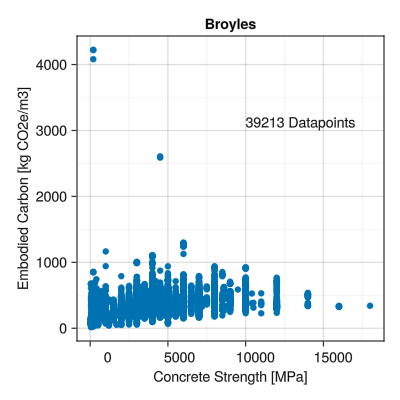

In [121]:
fc′_Broyles_psi = dataset_Broyles[!,"Concrete Compressive Strength (psi)"]
ec_Broyles = dataset_Broyles[!, "A1-A3 Global Warming Potential (kg CO2-eq)"]

#number formatting
printx(x,N) = sprintf1("%10.$(N)f",x)


f1 = Figure(size = (400,400))
ax1 = Axis(f1[1,1],
title = "Broyles",
xlabel = "Concrete Strength [MPa]",
ylabel = "Embodied Carbon [kg CO2e/m3]",

xminorticks = 0:2500:20000,
xminorgridvisible = true,
yminorticks = 0:500:4000,
yminorgridvisible = true,
xtickformat =  x -> printx.(x,0))

scatter!(ax1, fc′_Broyles_psi, ec_Broyles)
text!(ax1, string(length(fc′_Broyles_psi)) *" Datapoints", position=(10000,3000))
f1


Here, we have 39213 datapoints similar to the paper, but there are some points that suspiciously high.<br> 
Therefore, we will remove those points.

In [122]:
# filter = ec_Broyles .> 800;
# deleteat!(dataset_Broyles, filter);
fc′_Broyles_psi = dataset_Broyles[!,"Concrete Compressive Strength (psi)"];
ec_Broyles = dataset_Broyles[!, "A1-A3 Global Warming Potential (kg CO2-eq)"];
#convert to MPa
fc′_Broyles_MPa = fc′_Broyles_psi*0.00689476;


Then, re-plot again.

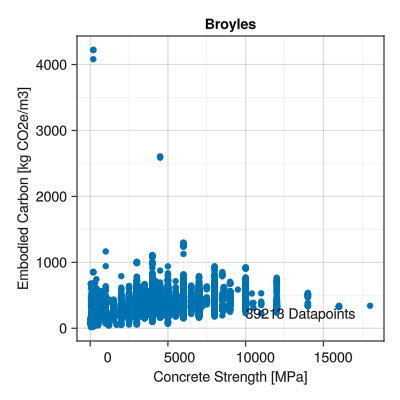

In [123]:
f2 = Figure(size = (400,400))
ax2 = Axis(f2[1,1],
title = "Broyles",
xlabel = "Concrete Strength [MPa]",
ylabel = "Embodied Carbon [kg CO2e/m3]",

xminorticks = 0:2500:20000,
xminorgridvisible = true,
yminorticks = 0:500:4000,
yminorgridvisible = true,
xtickformat =  x -> printx.(x,0))

scatter!(ax2, fc′_Broyles_psi, ec_Broyles)
text!(ax2, string(length(fc′_Broyles_psi)) *" Datapoints", position=(10000,100))


f2

Next, we will group the data as shown in the paper.

In [124]:
#define groups as done in the paper
label = Vector{Int64}(undef, length(fc′_Broyles_MPa))
for i in eachindex(fc′_Broyles_MPa)
    fc′ = fc′_Broyles_psi[i]
    if fc′ <2000
        label[i] = 1
    elseif fc′< 3000
        label[i] = 2
    elseif fc′< 4000
        label[i] = 3
    elseif fc′< 5000
        label[i] = 4
    elseif fc′< 6000
        label[i] = 5
    elseif fc′< 8000
        label[i] = 6
    elseif fc′< 10000
        label[i] = 7
    elseif fc′< 12000
        label[i] = 8
    else
        label[i] = 9
    end
end

# add the label into the dataset. 
dataset_Broyles[!,"Label"] = label;

Now, we plot the data again with the new labels.

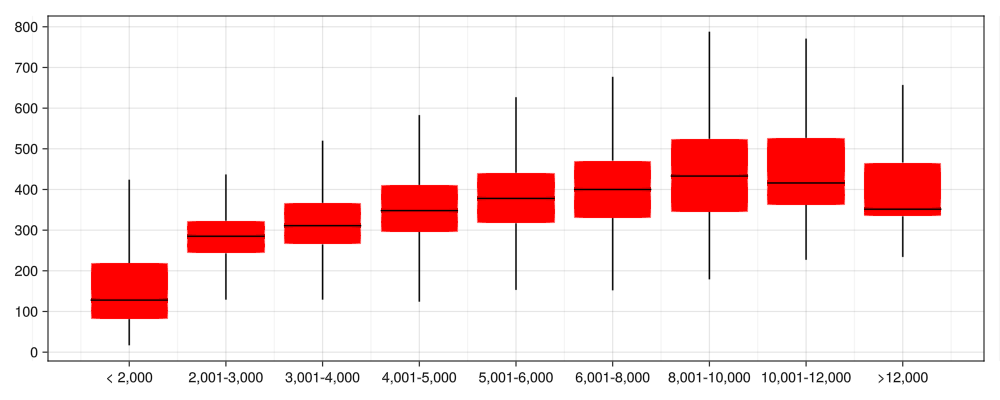

In [125]:
f3 = Figure(size = (1000,400))

ax3 = Axis(f3[1,1],
xticks=  1:9,
xminorgridvisible = true,
xtickformat =  x -> ["< 2,000",
"2,001-3,000",
"3,001-4,000",
"4,001-5,000",
"5,001-6,000",
"6,001-8,000",
"8,001-10,000",
"10,001-12,000",
">12,000"][Int.(x)],
yticks = 0:100:800)
boxplot!(ax3,label,ec_Broyles, color = :red, show_outliers = false)

# ax4 = Axis(f3[2,1],
# xticks=  1:9,
# xminorgridvisible = true,
# xtickformat =  x -> ["< 2,000",
# "2,001-3,000",
# "3,001-4,000",
# "4,001-5,000",
# "5,001-6,000",
# "6,001-8,000",
# "8,001-10,000",
# "10,001-12,000",
# ">12,000"][Int.(x)],
# yticks = 0:100:800)
# violin!(ax4,label,ec_Broyles, color = :red)

f3


(The paper)

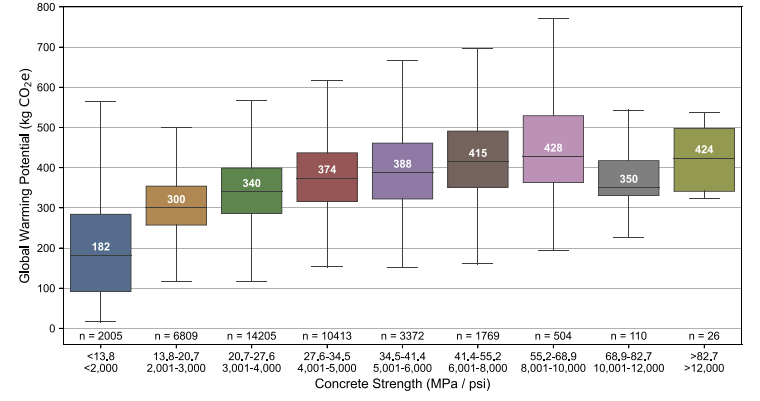

We will work on 4 batches. 
0. All of the dataset, grouped with the same labels.
1. Median line
2. Maximum line
3. Minimum line
4. A company line (Select one)

Check how many datapoint each company has.

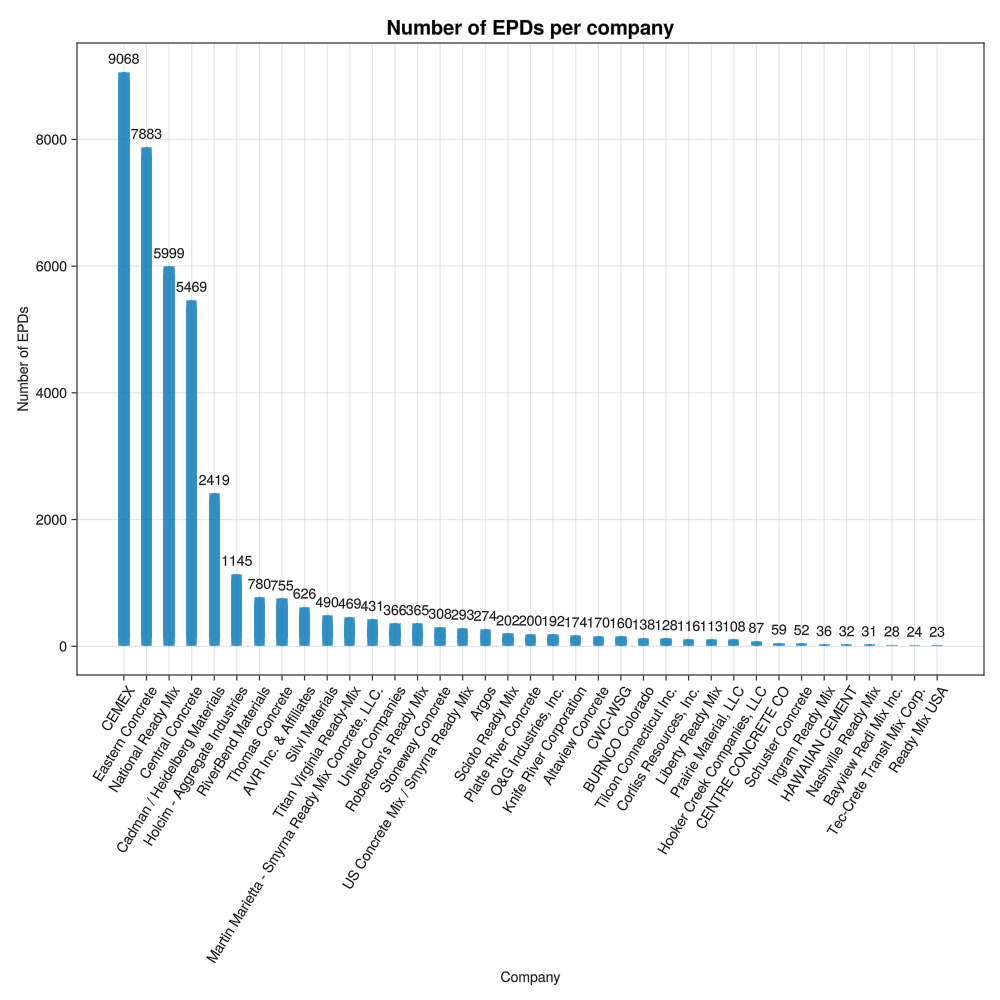

In [192]:
company_names = unique(dataset_Broyles[!, :Company])
company_n_EPDs = Dict{String, Int64}()
n_company = length(company_names)
for i in company_names
    company_n_EPDs[i] = size(dataset_Broyles[dataset_Broyles.Company .== i,:],1)
end
number_of_EPDs = [ company_n_EPDs[i] for i in company_names]
perm = sortperm(number_of_EPDs, rev= true)
company_names = company_names[perm]

f_company = Figure(size = (1000,1000))
a_company = Axis(f_company[1,1], xticks = (1:n_company, company_names), xticklabelrotation = 45, 
title = "Number of EPDs per company",
titlesize = 20, 
xlabel = "Company",
ylabel = "Number of EPDs")
barplot!(a_company,
   1:n_company,         
   number_of_EPDs[perm],
   bar_labels = number_of_EPDs[perm],
   gap = 0.5)

f_company

In [188]:
company_n_EPDs["CEMEX"]

9068

Let's create those lines


In [193]:
line1 = Vector{Float64}(undef, 9);
line2 = Vector{Float64}(undef, 9);
line3 = Vector{Float64}(undef, 9);


In [217]:
company_name = "CEMEX"
for i in 1:9
    sub_dataset = dataset_Broyles[dataset_Broyles.Label .== i, "A1-A3 Global Warming Potential (kg CO2-eq)"]
    first_quantile  = quantile!(sub_dataset, 0.25)
    second_quantile = quantile!(sub_dataset, 0.50)
    third_quantile  = quantile!(sub_dataset, 0.75)
    IQR = third_quantile - first_quantile
    line1[i] = second_quantile
    line2[i] = third_quantile + 1.5*IQR
    line3[i] = clamp(first_quantile - 1.5*IQR, minimum(sub_dataset), Inf)
    # line3[i] = quantile!(sub_dataset, 0)
    
    company_dataset = dataset_Broyles[dataset_Broyles.Company .== company_name, :]
    line4[i] = median(company_dataset[company_dataset.Label .== i,"A1-A3 Global Warming Potential (kg CO2-eq)"])
end


Let's check those lines out in a plot on the total dataset.

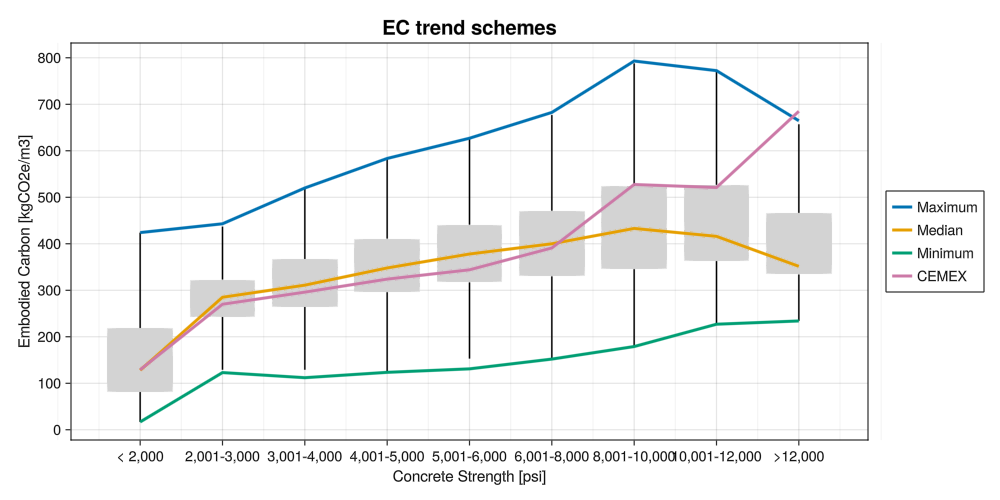

In [242]:
f4 = Figure(size = (1000,500))
ax4 = Axis(f4[1,1],
title = "EC trend schemes", titlesize = 20,
xlabel = "Concrete Strength [psi]",
xlabelsize = 15,
xticks=  1:9,
xminorgridvisible = true,
xtickformat =  x -> ["< 2,000",
"2,001-3,000",
"3,001-4,000",
"4,001-5,000",
"5,001-6,000",
"6,001-8,000",
"8,001-10,000",
"10,001-12,000",
">12,000"][Int.(x)],
ylabel = "Embodied Carbon [kgCO2e/m3]",
ylabelsize = 15,
yticks = 0:100:800)

#plot the previous data, greyed out
boxplot!(ax4,label,ec_Broyles, color = colorant"#D3D3D3", show_outliers = false, show_median=false)

lines!(ax4, 1:9,line2, label = "Maximum", linewidth = 3)
lines!(ax4, 1:9,line1, label = "Median",  linewidth = 3)
lines!(ax4, 1:9,line3, label = "Minimum", linewidth = 3)
lines!(ax4, 1:9,line4, label = company_name, linewidth = 3)
Legend(f4[1,2],ax4)
f4




Now, we will use those 4 lines to design beams <br>
We will choose the value in the middle of the interval. (or min or max of the interval) 

In [284]:
fc′_design = 0.00689476*[2000.0, 2500.0, 3500.0, 4500.0, 5500.0, 7000.0, 9000.0, 11000, 12000.0]
scheme1 = hcat(fc′_design, line1*10^(-9));
scheme2 = hcat(fc′_design, line2*10^(-9));
scheme3 = hcat(fc′_design, line3*10^(-9));
scheme4 = hcat(fc′_design, line4*10^(-9));


Initiate output matrix

In [285]:
all_output = Matrix{Float64}(undef, (4,length(fc′_design)))

4×9 Matrix{Float64}:
 6.9532e-310    6.9532e-310    1.59368e-314  …  1.0276e5      5.41512e-315
 6.9532e-310    6.9532e-310  -38.656            5.41512e-315  5.27643e6
 6.9532e-310  -38.656          0.0              5.27643e6     0.0
 6.9532e-310    1.0276e5       1.59368e-314     1.0276e5      5.41512e-315

Loop each scheme and add it to the output.

In [286]:
include("beamcalc.jl")

beam_design

In [287]:
for i in 1:length(fc′_design)
    rc_section1, serviceability1 = beam_design(scheme1[i,:]...)
    rc_section2, serviceability2 = beam_design(scheme2[i,:]...)
    rc_section3, serviceability3 = beam_design(scheme3[i,:]...)
    rc_section4, serviceability4 = beam_design(scheme4[i,:]...)

    results = [rc_section1, rc_section2, rc_section3, rc_section4]
    for rc_idx in eachindex(results) 
        rc = results[rc_idx]
        if isnothing(rc)
            all_output[rc_idx,i] = 0.0
        else
            all_output[rc_idx,i] = rc.embodied_carbon

        end
    end
end 


In [288]:
@show all_output


all_output = [0.0 0.0 0.0 0.0 1340.9673353491846 1272.5666984771192 1290.783207833608 1245.1013899398702 1121.0537087644655; 0.0 0.0 0.0 0.0 1799.3419137459193 1798.1924098080297 1963.4450391750347 1911.8924760032687 1707.111976678348; 0.0 0.0 0.0 0.0 886.2744804737086 811.132445698125 816.1829157204903 891.4752509963911 901.1356361740261; 0.0 0.0 0.0 0.0 1278.378035487783 1255.8211005940104 1467.3569385607325 1441.560356019581 1745.2467062871158]


4×9 Matrix{Float64}:
 0.0  0.0  0.0  0.0  1340.97   1272.57   1290.78   1245.1    1121.05
 0.0  0.0  0.0  0.0  1799.34   1798.19   1963.45   1911.89   1707.11
 0.0  0.0  0.0  0.0   886.274   811.132   816.183   891.475   901.136
 0.0  0.0  0.0  0.0  1278.38   1255.82   1467.36   1441.56   1745.25

Now, we plot the results. <br>
1. Plot with actual values
2. Plot with normalize values with the original ec3 data.



In [298]:
fc′_design

9-element Vector{Float64}:
 13.78952
 17.2369
 24.13166
 31.026419999999998
 37.92118
 48.26332
 62.052839999999996
 75.84236
 82.73712

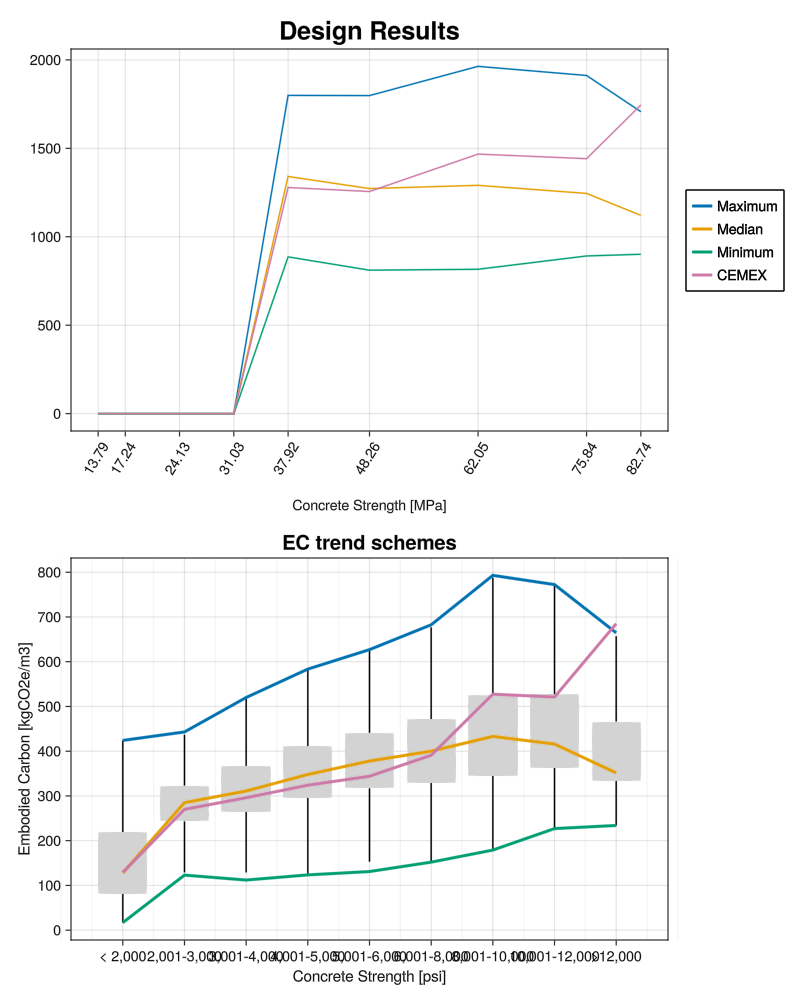

In [320]:
f_result = Figure(size = (800,1000),)#font = "Avenir Light")
ax_result = Axis(f_result[1,1], title = "Design Results", titlesize = 25,
xlabel = "Concrete Strength [MPa]",
xticks = fc′_design, xtickformat =  x -> printx.(x,2),
xticklabelrotation = 45)
lines!(ax_result, fc′_design,all_output[2,:], label = "Maximum" )
lines!(ax_result, fc′_design,all_output[1,:], label = "Median"  )
lines!(ax_result, fc′_design,all_output[3,:], label = "Minimum" )
lines!(ax_result, fc′_design,all_output[4,:], label = company_name)
Legend(f_result[1,2],ax_result)

ax4 = Axis(f_result[2,1],
title = "EC trend schemes", titlesize = 20,
xlabel = "Concrete Strength [psi]",
xlabelsize = 15,
xticks=  1:9,
xminorgridvisible = true,
xtickformat =  x -> ["< 2,000",
"2,001-3,000",
"3,001-4,000",
"4,001-5,000",
"5,001-6,000",
"6,001-8,000",
"8,001-10,000",
"10,001-12,000",
">12,000"][Int.(x)],
ylabel = "Embodied Carbon [kgCO2e/m3]",
ylabelsize = 15,
yticks = 0:100:800)

#plot the previous data, greyed out
boxplot!(ax4,label,ec_Broyles, color = colorant"#D3D3D3", show_outliers = false, show_median=false)

lines!(ax4, 1:9,line2, label = "Maximum", linewidth = 3)
lines!(ax4, 1:9,line1, label = "Median",  linewidth = 3)
lines!(ax4, 1:9,line3, label = "Minimum", linewidth = 3)
lines!(ax4, 1:9,line4, label = company_name, linewidth = 3)
Legend(f_result[1,2],ax4)

f_result


Let's check how much (multiples) of embodied carbon compared to the median line

norm_line1 = replace!(all_output[2, :] ./ all_output[1, :], NaN => 0.0) = [0.0, 0.0, 0.0, 0.0, 1.3418238209936524, 1.4130437421943596, 1.5211268842506804, 1.5355315570690995, 1.5227744784500898]
norm_line2 = replace!(all_output[1, :] ./ all_output[1, :], NaN => 0.0) = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
norm_line3 = replace!(all_output[3, :] ./ all_output[1, :], NaN => 0.0) = [0.0, 0.0, 0.0, 0.0, 0.6609217518657342, 0.637398767914332, 0.6323160316675754, 0.7159860700496392, 0.8038291378271116]
norm_line4 = replace!(all_output[4, :] ./ all_output[1, :], NaN => 0.0) = [0.0, 0.0, 0.0, 0.0, 0.953325261390425, 0.9868410843194716, 1.1367958071158035, 1.1577855166390894, 1.5567913407204952]


norm_line1 = replace!(line1 ./ line1, NaN => 0.0) = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
norm_line2 = replace!(line2 ./ line1, NaN => 0.0) = [3.3130859375000004, 1.5543859649122806, 1.6720257234726688, 1.6767241379310345, 1.6587301587301588, 1.70625, 1.8314087759815243, 1.8566706730769231, 1.8908250355618776]
norm_line3 = replace!(line3 ./ line1, NaN => 0.0) = [0.13125, 0.43157894736842106, 0.36012861736334406, 0.35488505747126436, 0.34656084656084657, 0.38, 0.4133949191685912, 0.5456730769230769, 0.6657183499288762]
norm_line4 = replace!(line4 ./ line1, NaN => 0.0) = [1.0078125, 0.9473684210526315, 0.9517684887459807, 0.9310344827586207, 0.91005291005291, 0.9775, 1.21824480369515, 1.2524038461538463, 1.9487908961593172]
[9, 9, 9, 9]


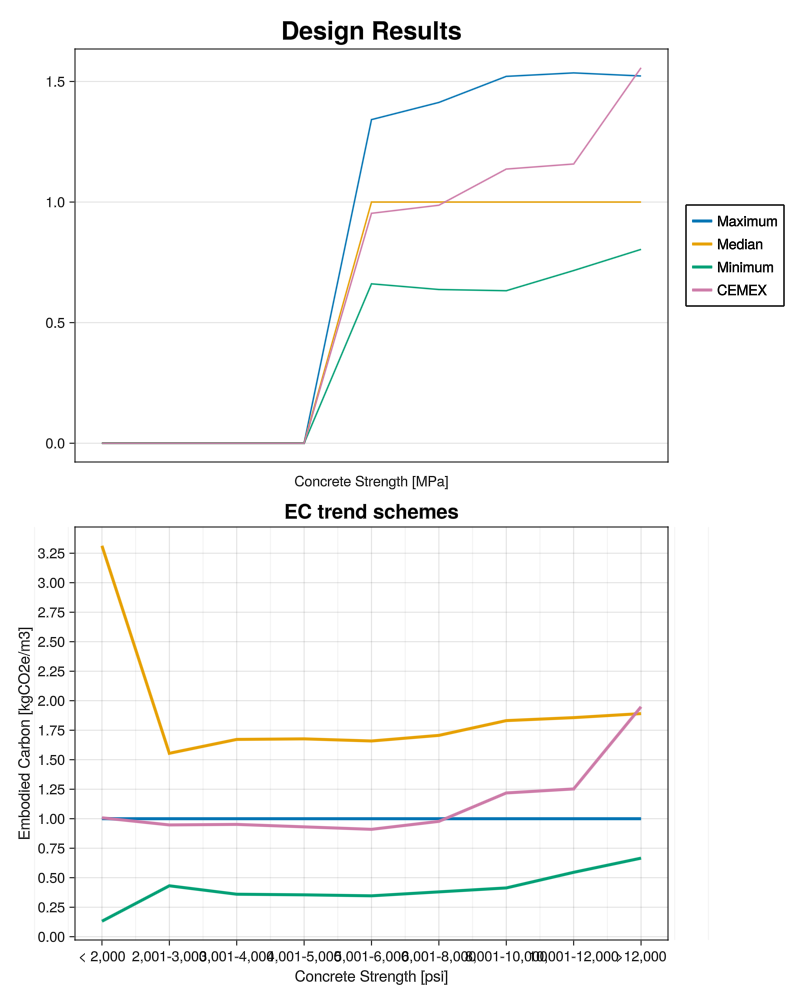

In [334]:
f_result = Figure(size = (800,1000),)#font = "Avenir Light")
ax_result = Axis(f_result[1,1], title = "Design Results", titlesize = 25,
xlabel = "Concrete Strength [MPa]",
xticks = fc′_design, xtickformat =  x -> printx.(x,2),
xticklabelrotation = 45)
@show norm_line1 = replace!(all_output[2,:]./all_output[1,:], NaN => 0.0)
@show norm_line2 = replace!(all_output[1,:]./all_output[1,:], NaN => 0.0)
@show norm_line3 = replace!(all_output[3,:]./all_output[1,:], NaN => 0.0)
@show norm_line4 = replace!(all_output[4,:]./all_output[1,:], NaN => 0.0)

lines!(ax_result,norm_line1 , label = "Maximum" )
lines!(ax_result,norm_line2 , label = "Median"  )
lines!(ax_result,norm_line3 , label = "Minimum" )
lines!(ax_result,norm_line4 , label = company_name)
Legend(f_result[1,2],ax_result)

ax4 = Axis(f_result[2,1],
title = "EC trend schemes", titlesize = 20,
xlabel = "Concrete Strength [psi]",
xlabelsize = 15,
xticks=  1:9,
xminorgridvisible = true,
xtickformat =  x -> ["< 2,000",
"2,001-3,000",
"3,001-4,000",
"4,001-5,000",
"5,001-6,000",
"6,001-8,000",
"8,001-10,000",
"10,001-12,000",
">12,000"][Int.(x)],
ylabel = "Embodied Carbon [kgCO2e/m3]",
ylabelsize = 15,
yticks = 0:0.25:5)

#plot the previous data, greyed out
# boxplot!(ax4,label,ec_Broyles, color = colorant"#D3D3D3", show_outliers = false, show_median=false)
@show norm_line1 = replace!(line1./line1, NaN => 0.0)
@show norm_line2 = replace!(line2./line1, NaN => 0.0)
@show norm_line3 = replace!(line3./line1, NaN => 0.0)
@show norm_line4 = replace!(line4./line1, NaN => 0.0)
println(length.([norm_line1,norm_line2, norm_line3, norm_line4]))
lines!(ax4, 1:9, norm_line1, label = "Maximum", linewidth = 3)
lines!(ax4, 1:9, norm_line2, label = "Median",  linewidth = 3)
lines!(ax4, 1:9, norm_line3, label = "Minimum", linewidth = 3)
lines!(ax4, 1:9, norm_line4, label = company_name, linewidth = 3)
Legend(f_result[1,2],ax4)

f_result

Eventhough the embodied carbon coefficients of the maximum line is als